<a href="https://colab.research.google.com/github/Glenn-Matias/fake_news_classifier/blob/main/MP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
##import the required libraries and APIs
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
print(tf.__version__)

2.6.0


In [118]:
!wget --no-check-certificate \
    https://s3.us-east-2.amazonaws.com/blaisecruz.com/datasets/fakenews/fakenews.zip
!unzip "/content/fakenews.zip" -d "/content/fakenews"

--2021-09-18 09:46:07--  https://s3.us-east-2.amazonaws.com/blaisecruz.com/datasets/fakenews/fakenews.zip
Resolving s3.us-east-2.amazonaws.com (s3.us-east-2.amazonaws.com)... 52.219.102.217
Connecting to s3.us-east-2.amazonaws.com (s3.us-east-2.amazonaws.com)|52.219.102.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1313458 (1.3M) [application/zip]
Saving to: ‘fakenews.zip.2’

fakenews.zip.2      100%[===================>]   1.25M  3.52MB/s    in 0.4s    

2021-09-18 09:46:07 (3.52 MB/s) - ‘fakenews.zip.2’ saved [1313458/1313458]

Archive:  /content/fakenews.zip
replace /content/fakenews/fakenews/full.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/fakenews/fakenews/full.csv  


In [142]:
data = pd.read_csv("./fakenews/fakenews/full.csv")
data['article'] = data['article'].str.lower()
data.head()

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


In [143]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3206 entries, 0 to 3205
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    3206 non-null   int64 
 1   article  3206 non-null   object
dtypes: int64(1), object(1)
memory usage: 50.2+ KB


In [144]:
##store headlines and labels in respective lists
news = list(data['article'])
labels = list(data['label'])

In [145]:
data.shape

(3206, 2)

In [146]:
max_length = max([len(x.split(" ")) for x in data["article"]])
print(max_length)
# max_length = 120

1076


In [147]:
from collections import Counter
results = Counter()
data['article'].str.lower().str.split().apply(results.update)
vocab_size = len(results)

In [148]:
##define tokenizing and padding parameters
# vocab_size = 10000 # should be the number of distinct words in the dataset
max_length = 120 # should be the max length all the training set
embedding_dim = 16
trunc_type='post' # drops the excess sequences at the end of the sequence
padding_type='post' # add zeroesto the end part of the sequence
oov_tok = "<OOV>"


In [149]:
# ##sentences
# training_sentences = news[0:training_size]
# testing_sentences = news[training_size:]

# ##labels
# training_labels = labels[0:training_size]
# testing_labels = labels[training_size:]


from sklearn.model_selection import train_test_split
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(news, labels, test_size=0.20, random_state=33)


In [150]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

print(word_index) # show the tokenized words

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

{'<OOV>': 1, 'sa': 2, 'ng': 3, 'ang': 4, 'na': 5, 'mga': 6, 'at': 7, 'ni': 8, 'ay': 9, 'si': 10, 'the': 11, 'of': 12, 'hindi': 13, 'ito': 14, 'and': 15, 'to': 16, 'pa': 17, 'isang': 18, 'para': 19, 'naman': 20, 'kay': 21, 'kung': 22, 'may': 23, 'dahil': 24, 'ayon': 25, 'sabi': 26, 'niya': 27, 'kanyang': 28, 'duterte': 29, 'lang': 30, 'daw': 31, 'noong': 32, 'a': 33, 'din': 34, 'in': 35, 'i': 36, 'siya': 37, 'nang': 38, 'rin': 39, 'nito': 40, 'is': 41, 'ilang': 42, 'kanilang': 43, 'that': 44, 'source': 45, 'mula': 46, 'ko': 47, 'nila': 48, 'video': 49, 'for': 50, 'umano': 51, 'sinabi': 52, 'naging': 53, 'pag': 54, 'matapos': 55, 'pangulong': 56, 'po': 57, 'sila': 58, 'pilipinas': 59, 'ngayon': 60, 'miss': 61, 'we': 62, 'natin': 63, 'pero': 64, 'city': 65, 'isa': 66, 'o': 67, 'media': 68, 'manila': 69, 'be': 70, 'ako': 71, 'catriona': 72, 'it': 73, 'wala': 74, 'pang': 75, 'laban': 76, 'lamang': 77, 'kaya': 78, 'mo': 79, 'you': 80, 'pangulo': 81, 'ka': 82, 'pahayag': 83, 'bilang': 84, 'on

In [151]:
# convert lists into numpy arrays to make it work with TensorFlow 2.x
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [170]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),

    # Uncomment for LSTM
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # Uncomment for CNN
    # tf.keras.layers.Conv1D(64, 5, activation='relu'),
    # UNcomment for simple nn
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

##compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 120, 16)           1011872   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 120, 128)          41472     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_40 (Dense)             (None, 24)                1560      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 25        
Total params: 1,096,145
Trainable params: 1,096,145
Non-trainable params: 0
_________________________________________________________________


In [171]:
num_epochs = 30
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose=2)

Epoch 1/30
81/81 - 26s - loss: 0.5155 - accuracy: 0.7594 - val_loss: 0.2535 - val_accuracy: 0.9065
Epoch 2/30
81/81 - 18s - loss: 0.1384 - accuracy: 0.9536 - val_loss: 0.2049 - val_accuracy: 0.9174
Epoch 3/30
81/81 - 18s - loss: 0.0645 - accuracy: 0.9836 - val_loss: 0.1889 - val_accuracy: 0.9393
Epoch 4/30
81/81 - 18s - loss: 0.0192 - accuracy: 0.9965 - val_loss: 0.1809 - val_accuracy: 0.9517
Epoch 5/30
81/81 - 18s - loss: 0.0064 - accuracy: 0.9984 - val_loss: 0.3256 - val_accuracy: 0.9299
Epoch 6/30
81/81 - 18s - loss: 0.0040 - accuracy: 0.9996 - val_loss: 0.2132 - val_accuracy: 0.9533
Epoch 7/30
81/81 - 18s - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.3042 - val_accuracy: 0.9424
Epoch 8/30
81/81 - 18s - loss: 4.7150e-04 - accuracy: 1.0000 - val_loss: 0.3624 - val_accuracy: 0.9377
Epoch 9/30
81/81 - 18s - loss: 2.4401e-04 - accuracy: 1.0000 - val_loss: 0.3973 - val_accuracy: 0.9346
Epoch 10/30
81/81 - 20s - loss: 1.8530e-04 - accuracy: 1.0000 - val_loss: 0.4282 - val_accuracy: 0.93

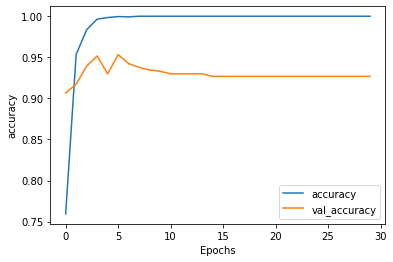

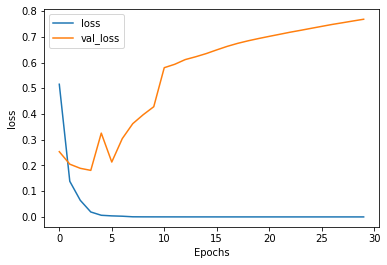

In [177]:
import matplotlib.pyplot as plt

##plot the scores from history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.legend([string, 'val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [173]:
# sentence = ["Duterte, pinakamagaling na presidente. ayon sa ulat ni mocha uson", 
#             "Pilipinas, inuulan ng bagyo", 
#             "Nilindol ang Batangas", 
#             "Talagang hindi natatakot si President Duterte sa mga Threats na kanyang natatanggap dahil malakas ang paniniwala niya sa ating Poong may Kapal. Kaya mahal na mahal namin kayo President",
#             "Napaka fake news niyo ABS CBN .... galing niyo mag edit, tingnan niyo tunay na post ni MOCHA USON BLOG nandun yung tunay na post video hindi photo... nimal abs cbn madami na kayong naloloko na mga tangang tao",
#             "Sobra Sobrang kahihiyan ang mga ginagawa ng mga PARI ngayon! Dapat sa mga PARING Rapist Maniac at Malilibog ay putulan ng TARUGO!",
#             "Aquino nagalit dahil papalitan ang NAIA ng ‘Manila International Airport?",
#             "Kinumpirma mismo ni Leni Robredo na siya ang Spotted sa Boston, 'Namumulot ng Basura'!"
#             ]

# ##prepare the sequences of the sentences in question
# sequences = tokenizer.texts_to_sequences(sentence) # displays the sequences of words in encoded form
# padded_seqs = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# print(model.predict(padded_seqs))

In [178]:
sentence = ["Duterte, pinakamagaling na presidente. ayon sa ulat ni mocha uson", 
            "Pilipinas, inuulan ng bagyo", 
            "Nilindol ang Batangas", 
            "Talagang hindi natatakot si President Duterte sa mga Threats na kanyang natatanggap dahil malakas ang paniniwala niya sa ating Poong may Kapal. Kaya mahal na mahal namin kayo President",
            "Napaka fake news niyo ABS CBN .... galing niyo mag edit, tingnan niyo tunay na post ni MOCHA USON BLOG nandun yung tunay na post video hindi photo... nimal abs cbn madami na kayong naloloko na mga tangang tao",
            "Sobra Sobrang kahihiyan ang mga ginagawa ng mga PARI ngayon! Dapat sa mga PARING Rapist Maniac at Malilibog ay putulan ng TARUGO!",
            "Aquino nagalit dahil papalitan ang NAIA ng ‘Manila International Airport?",
            "Kinumpirma mismo ni Leni Robredo na siya ang Spotted sa Boston, 'Namumulot ng Basura'!"
            ]
sentence = [x.lower() for x in sentence]



##prepare the sequences of the sentences in question
sequences = tokenizer.texts_to_sequences(sentence) # displays the sequences of words in encoded form
padded_seqs = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predictions_list = model.predict(padded_seqs)
predictions_list = ['%f' % x for x in predictions_list]

print(predictions_list)

['0.999986', '0.000020', '0.000011', '0.000119', '0.999989', '0.000027', '0.000045', '0.999985']


In [175]:


# 30 epochs , 10,000 vocab, preserved case
# Rnn 
# ['0.221651', '0.000248', '0.000216', '0.020854', '1.000000', '0.000059', '0.004214', '0.001713']
# LSTM
# ['0.998617', '0.285047', '0.107714', '0.659346', '0.999892', '0.000024', '0.796265', '0.322125']
# Base line
# ['0.370136', '0.021366', '0.010388', '0.124484', '0.999182', '0.015307', '0.095852', '0.063588']


# 30 epochs, true number for vocab (lowercase distinct), preserved case
# Rnn 
# LSTM
# ['0.681796', '0.019023', '0.019576', '0.303410', '0.999965', '0.024431', '0.200263', '0.136963']
# Base line
# ['0.295957', '0.031743', '0.017272', '0.105267', '0.997630', '0.039485', '0.109363', '0.112274']


# 30 epochs, true number for vocab, lowercased
# Rnn 
# ['0.999986', '0.000020', '0.000011', '0.000119', '0.999989', '0.000027', '0.000045', '0.999985']
# LSTM
# ['0.517442', '0.007209', '0.005416', '0.133676', '0.999818', '0.006994', '0.028861', '0.043192']
# Base line
# ['0.423616', '0.064008', '0.036655', '0.191023', '0.998666', '0.067993', '0.210841', '0.169035']

In [176]:
data[data['label']==1]['article']

1603    Isiniwalat ng isang tribal leader ang kabalbal...
1604    Kilala ang Univeristy of the Philippines (UP) ...
1605    Ayon kay Tourism Secretary Bernadette Romulo-P...
1606    Sa opisyal na pagpapakilala ng mga taga-oposis...
1607    Hindi pinalampas ni dating Presidential Commun...
                              ...                        
3201    Hindi pa nai-enjoy ni Giacomo Filibeck ang Pil...
3202    Sa isang pahayag, binatikos ng Liberal Party (...
3203    Panoorin nyo yung reaction video na ito ni Mr....
3204    Para sa mga magkakapatid na laging nagtatalo l...
3205    Grabe ibang klase talaga si Vice Ganda kung ma...
Name: article, Length: 1603, dtype: object